<a href="https://www.kaggle.com/code/handandegerli/cltv-prediction?scriptVersionId=179987631" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
##############################################################
# BG-NBD ve Gamma-Gamma ile CLTV Prediction
##############################################################

# 1. Verinin Hazırlanması (Data Preperation)
# 2. BG-NBD Modeli ile Expected Number of Transaction
# 3. Gamma-Gamma Modeli ile Expected Average Profit
# 4. BG-NBD ve Gamma-Gamma Modeli ile CLTV'nin Hesaplanması
# 5. CLTV'ye Göre Segmentlerin Oluşturulması
# 6. Çalışmanın fonksiyonlaştırılması


##############################################################
# 1. Verinin Hazırlanması (Data Preperation)
##############################################################

# Bir e-ticaret şirketi müşterilerini segmentlere ayırıp bu segmentlere göre
# pazarlama stratejileri belirlemek istiyor.

# Veri Seti Hikayesi

# https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

# Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının
# 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içeriyor.

# Değişkenler

# InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.
# StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
# Description: Ürün ismi
# Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
# InvoiceDate: Fatura tarihi ve zamanı.
# UnitPrice: Ürün fiyatı (Sterlin cinsinden)
# CustomerID: Eşsiz müşteri numarası
# Country: Ülke ismi. Müşterinin yaşadığı ülke.




**PF * AOV değerlerine olasılık özelliği kazandırıp, ve bütün kitle davranışlarını göz önünde bulundaracak şekilde kitlenin satın alma davranışını modelleyip genel kitle davranışını bir bireyin özelliklerine indirgedikten sonra birey üzerinde beklenen satın alma sayılarını BG/NBD modeliyle; ortalama kazançları da GAmma Gamma Submodeli ile hesaplayacağız. O nedenle conditional expected: modellenen genel kitle davranısı kişi özelinde işlemlerden geçiyor(condition) ve expected value lar bulunuyor.**

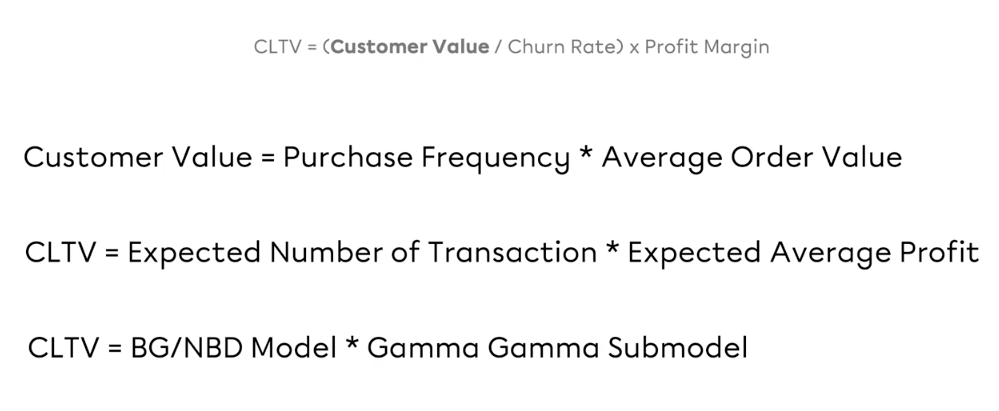

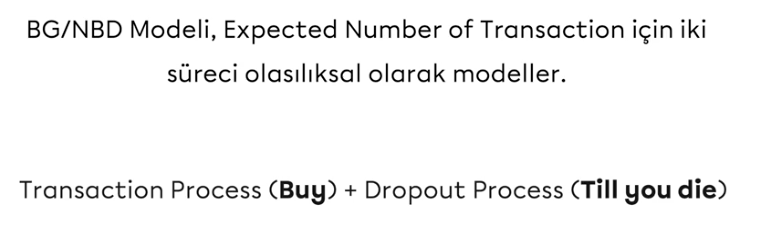

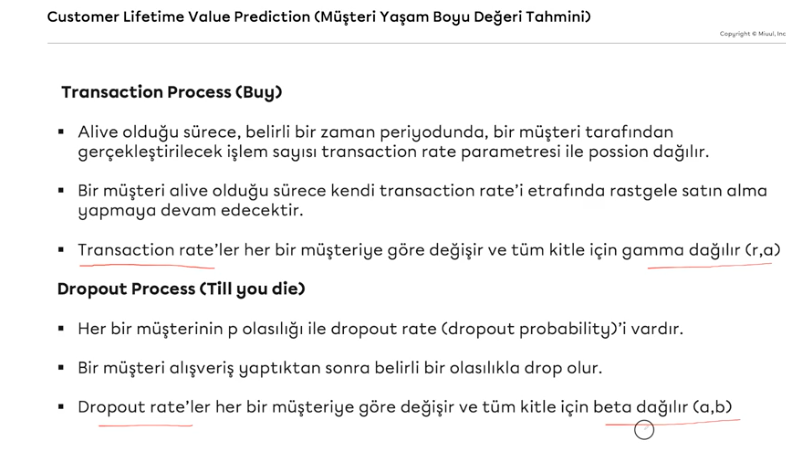

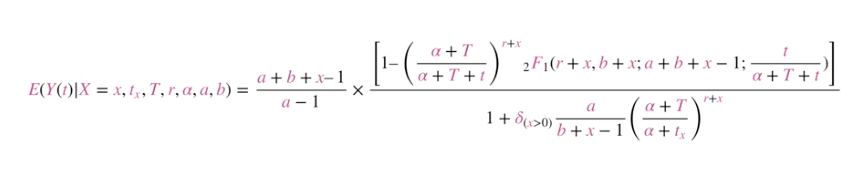

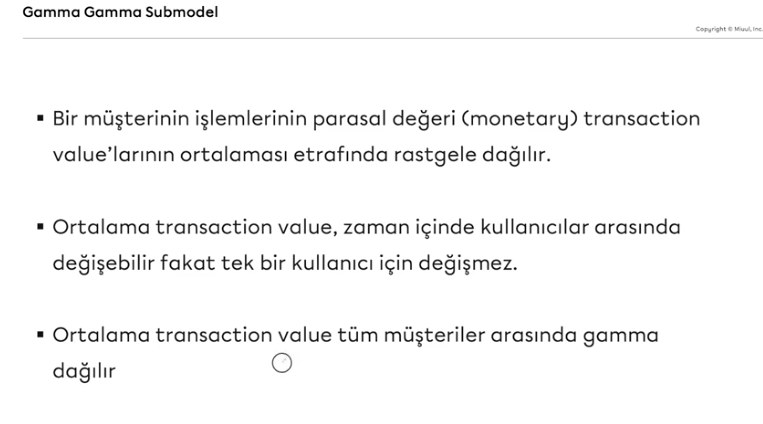

In [2]:
##########################
# Gerekli Kütüphane ve Fonksiyonlar
##########################

!pip install lifetimes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.7 MB/s eta 0:00:00


In [3]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler


#boxplot ya da iqr yontemi olarak gecen bir yontemle aykırı degerler tespit edilecek
#aykırı degerleri baskılama yontemi ile baskılayıp belirlemiş oldugumuz
#eşik değerleri ile degiştircez.
#quartile degerleri sonucları etkiliyor burada onemli
#outlier_thresholds func ile kendisine girilen verilerle eşik değeri belirleriz
#daha sonra aykırı değeri eşik değerle degiştirmek için
#replace_with_thresholds func kullanırız
#yuzde 25 ve 75 ceyrek degerler alınır ama proje bazında degısıyor 
#bız burada bıldığımız için 0.01 0.99 aldık, ucundan tıraslıyoruz
#en problemli aykırı degerleri baskılıcaz

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


# replace_with_thresholds func da low limit pronblem olmıcak cunku
#biz datayı ayıklıcaz. quantitiyde vs aykrıı deger olmıcak.
#o neden le commentledik

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [4]:
#########################
# Verinin Okunması
#########################

df_ = pd.read_excel("/kaggle/input/datasetforprediction/online_retail_II.xlsx",
                    sheet_name="Year 2010-2011")



In [5]:
df = df_.copy()

In [6]:
df.describe().T
#- degerler var problem, max ile çeyreklikler arasında cok fark var muhtemelen aykırı cok var

,count,mean,min,25%,50%,75%,max,std
Quantity,541910.0000,9.5522,-80995.0000,1.0000,3.0000,10.0000,80995.0000,218.0810
InvoiceDate,541910,2011-07-04 13:35:22.342307584,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
Price,541910.0000,4.6111,-11062.0600,1.2500,2.0800,4.1300,38970.0000,96.7598
Customer ID,406830.0000,15287.6842,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000,1713.6031


In [7]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [8]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [9]:
#########################
# Veri Ön İşleme
#########################
df = df[~df["Invoice"].str.contains("C", na=False)]


In [10]:
df.describe().T
#ceyrekte 10.000 maxta is 80.0000 aykırı deger olabilir

,count,mean,min,25%,50%,75%,max,std
Quantity,532622.0000,10.2400,-9600.0000,1.0000,3.0000,10.0000,80995.0000,159.5934
InvoiceDate,532622,2011-07-04 17:06:36.405631488,2010-12-01 08:26:00,2011-03-28 12:13:00,2011-07-20 11:54:00,2011-10-19 12:21:00,2011-12-09 12:50:00,NaN
Price,532622.0000,3.8476,-11062.0600,1.2500,2.0800,4.1300,13541.3300,41.7580
Customer ID,397925.0000,15294.3086,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000,1713.1727


In [11]:
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]
df.dropna(inplace=True)

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

df["TotalPrice"] = df["Quantity"] * df["Price"]

today_date = dt.datetime(2011, 12, 11)


In [12]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0000,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,15.3000
1,536365,71053,WHITE METAL LANTERN,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0000,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,22.0000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400


In [13]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397885.0000,11.8308,1.0000,2.0000,6.0000,12.0000,298.5000,25.5231
InvoiceDate,397885,2011-07-10 23:41:56.419316992,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
Price,397885.0000,2.8935,0.0010,1.2500,1.9500,3.7500,37.0600,3.2272
Customer ID,397885.0000,15294.4169,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000,1713.1444
TotalPrice,397885.0000,20.6298,0.0010,4.6800,11.8000,19.8000,3268.5750,51.8285


In [14]:
#ileride customer id ye gore groupby yapıp invoicea gore kırarsak
#total price sumı alırsam mehmet beyin bir faturaya ne kadar bedel odediğini tespit edebilrim.
#ya ad invice değilde cust ıd ye gore kırarsak o zamn customer basına odenen totalprice sumı buluruz

In [15]:
########################
# Lifetime Veri Yapısının Hazırlanması
#########################

# recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde)
# T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
# frequency: tekrar eden toplam satın alma sayısı (frequency>1)
# monetary: satın alma başına ortalama kazanç()toplam kazanc degil


cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'Invoice': lambda Invoice: Invoice.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [16]:
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0000            0        326        1   310.4400
12347.0000          365        368        7  4310.0000
12348.0000          282        359        4  1770.7800
12349.0000            0         19        1  1491.7200
12350.0000            0        311        1   331.4600

In [17]:
cltv_df.columns = cltv_df.columns.droplevel(0)


In [18]:
cltv_df.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.0000,0,326,1,310.4400
12347.0000,365,368,7,4310.0000
12348.0000,282,359,4,1770.7800
12349.0000,0,19,1,1491.7200
12350.0000,0,311,1,331.4600


In [19]:
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

In [20]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,0,326,1,310.4400
12347.0000,365,368,7,4310.0000
12348.0000,282,359,4,1770.7800
12349.0000,0,19,1,1491.7200
12350.0000,0,311,1,331.4600


In [21]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
#ortalama kazanc hesapladık
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0000,130.4486,132.0396,0.0000,0.0000,92.5000,251.7500,373.0000
T,4338.0000,223.8310,117.8546,1.0000,113.0000,249.0000,327.0000,374.0000
frequency,4338.0000,4.2720,7.6980,1.0000,1.0000,2.0000,5.0000,209.0000
monetary,4338.0000,364.1185,367.2582,3.4500,176.8512,288.2255,422.0294,6207.6700


In [22]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]


In [23]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2845.0000,198.9054,113.8670,0.0000,98.0000,207.0000,299.0000,373.0000
T,2845.0000,258.7842,102.9909,3.0000,192.0000,283.0000,359.0000,374.0000
frequency,2845.0000,5.9891,9.0442,2.0000,2.0000,4.0000,6.0000,209.0000
monetary,2845.0000,372.1736,349.3012,3.4500,191.0733,300.4873,436.8700,5724.3026


In [24]:

cltv_df["recency"] = cltv_df["recency"] / 7

cltv_df["T"] = cltv_df["T"] / 7


In [25]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2845.0000,28.4151,16.2667,0.0000,14.0000,29.5714,42.7143,53.2857
T,2845.0000,36.9692,14.7130,0.4286,27.4286,40.4286,51.2857,53.4286
frequency,2845.0000,5.9891,9.0442,2.0000,2.0000,4.0000,6.0000,209.0000
monetary,2845.0000,372.1736,349.3012,3.4500,191.0733,300.4873,436.8700,5724.3026


In [26]:
##############################################################
# 2. BG-NBD Modelinin Kurulması
##############################################################
#BG-NBD Modeli bize en cok olabilirlik yon ile beta ve gamma 
#dagılımlarının parametrelerini bıulmakta ve bir tahmin
#yapabilmemeiz ilgili modli olusturur
bgf = BetaGeoFitter(penalizer_coef=0.001)

#bgf modeli bu bunu fit ediyorz
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

#2845 gozlemde bize alpha beta degerleri getirir

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

In [27]:
################################################################
# 1 hafta içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
################################################################
#teoride transaction conditional_expected_number_of_purchases_up_to_time
#1 haftalık tahmin yap diyoruz
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)


Customer ID
12748.0000   3.2495
14911.0000   3.1264
17841.0000   1.9402
13089.0000   1.5374
14606.0000   1.4639
15311.0000   1.4336
12971.0000   1.3569
14646.0000   1.2064
13408.0000   0.9862
18102.0000   0.9685
dtype: float64

In [28]:
#conditional_expected_number_of_purchases_up_to_time yerinde predict de aynı sonucu verir
#ama gamma gamma da gecerli değil
bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)



Customer ID
12748.0000   3.2495
14911.0000   3.1264
17841.0000   1.9402
13089.0000   1.5374
14606.0000   1.4639
15311.0000   1.4336
12971.0000   1.3569
14646.0000   1.2064
13408.0000   0.9862
18102.0000   0.9685
dtype: float64

In [29]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])


In [30]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413
12348.0000,40.2857,51.2857,4,442.6950,0.0920
12352.0000,37.1429,42.4286,8,219.5425,0.1824
12356.0000,43.1429,46.5714,3,937.1433,0.0862
12358.0000,21.2857,21.5714,2,575.2100,0.1223


In [31]:
################################################################
# 1 ay içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
################################################################

bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)



Customer ID
12748.0000   12.9633
14911.0000   12.4722
17841.0000    7.7398
13089.0000    6.1330
14606.0000    5.8399
15311.0000    5.7191
12971.0000    5.4131
14646.0000    4.8119
13408.0000    3.9341
18102.0000    3.8636
dtype: float64

In [32]:
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])



In [33]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635
12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668
12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271
12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435
12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862


In [34]:
#1 aylık periyotta sirket satıs sayısı
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

1776.8934732202908

In [35]:
################################################################
# 3 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir?
################################################################

bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [36]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month
Customer ID,,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,1.6784
12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668,1.0920
12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271,2.1631
12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,1.0222
12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862,1.4388


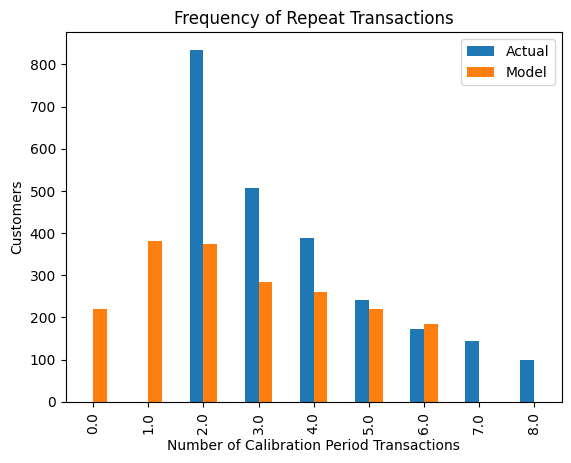

In [37]:
################################################################
# Tahmin Sonuçlarının Değerlendirilmesi
################################################################

plot_period_transactions(bgf)
plt.show()
# cok ıı bır model degil tahmin basarısı cok abartmıcak sekılde gerceklesmı 

In [38]:
##############################################################
# 3. GAMMA-GAMMA Modelinin Kurulması
##############################################################

ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [39]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)


Customer ID
12415.0000   5772.1782
12590.0000   5029.4196
12435.0000   4288.9440
12409.0000   3918.8128
14088.0000   3917.1297
18102.0000   3870.9969
12753.0000   3678.5783
14646.0000   3654.8148
15749.0000   3216.0523
14096.0000   3196.4361
dtype: float64

In [40]:

cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)



,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,4.5080,5772.1782
12590.0000,0.0000,30.2857,2,4591.1725,0.0115,0.0460,0.1363,5029.4196
12435.0000,26.8571,38.2857,2,3914.9450,0.0763,0.3041,0.9035,4288.9440
12409.0000,14.7143,26.1429,3,3690.8900,0.1174,0.4674,1.3854,3918.8128
14088.0000,44.5714,46.1429,13,3864.5546,0.2603,1.0379,3.0896,3917.1297
18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,11.5112,3870.9969
12753.0000,48.4286,51.8571,6,3571.5650,0.1261,0.5028,1.4973,3678.5783
14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,14.3340,3654.8148
15749.0000,13.8571,47.5714,3,3028.7800,0.0280,0.1116,0.3320,3216.0523


In [41]:

##############################################################
# 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
##############################################################

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 aylık
                                   freq="W",  # T'nin frekans bilgisi. haftalık mı gunluk mu aylık mı yıllık mı
                                   discount_rate=0.01)

cltv.head()


Customer ID
12347.0000   1128.4477
12348.0000    538.8089
12352.0000    517.5000
12356.0000   1083.0903
12358.0000    966.6727
Name: clv, dtype: float64

In [42]:
cltv = cltv.reset_index()

In [43]:
#cltv_df ile left join ile birleştir
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)
#clv : customer_lifetime_value bu isimle return etmiş

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,14.3340,3654.8148,55741.0845
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,11.5112,3870.9969,47412.5801
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,2.8955,8.5526,3196.4361,29061.6614
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,4.5080,5772.1782,27685.1000
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,12.4722,37.1641,692.3264,27377.4115
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7474,2.9815,8.8830,2874.1987,27166.0643
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8775,3.5005,10.4298,2110.7542,23424.4032
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5088,2.0298,6.0476,2950.5801,18986.6123
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9068,5.6801,2223.8850,13440.4131
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8008,3.1946,9.5186,1280.2183,12966.1347


***normal recency de biz dusuk olmasını ısterdik buradaki recencyde recency nin yuksek olması buy till you die kavramı derki senin duzenli ortalamada bir işlem kapasitesi olan bir musterin churn olmadıysa musterinin recencysi arttıkca satın alma uzelliği artar. alısveriş anında hemen alma duyusu tatmın olur gb nedenlerle yarı churn drop out olur. kenarda bekler bekledikçe satın alma ıhtıyacı ortaya cıkmaya baslar.**

**3. sıradaki yası T si ve rcency si birbirine yakın ama dusuk ama monetary si yuksek geri gelcek diyo potansiyelli musteri de yakaladı.**

**profiti az olan da cıktı karsıma**

**yeni musterim potansiyeli var cunku monetary si yuksek**
**eski musterim potansiyeli var cunku frequencysi yuksek**

In [44]:
##############################################################
# 5. CLTV'ye Göre Segmentlerin Oluşturulması
##############################################################

cltv_final

cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

cltv_final.sort_values(by="clv", ascending=False).head(50)

cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})




Customer ID                          recency                        T                    frequency               monetary                      expected_purc_1_week                 expected_purc_1_month                 expected_purc_3_month                  expected_average_profit                        clv                       
              count           sum       mean   count        sum    mean count        sum    mean     count   sum    mean    count         sum     mean                count      sum   mean                 count      sum   mean                 count       sum   mean                   count         sum     mean count          sum      mean
segment                                                                                                                                                                                                                                                                                                                                           
D               712 11077635.0000 15558.4761     712 15716.5714 22.0738   712 28811.0000 40.4649       712  2182  3.0646      712 130981.7123 183.9631                  712  50.5898 0.0711                   712 201.4774 0.2830                   712  598.0905 0.8400                     712 141999.6650 199.4377   712  102027.4901  143.2970
C               711 10885150.0000 15309.6343     711 21806.1429 30.6697   711 27097.0000 38.1111       711  2912  4.0956      711 193174.9847 271.6948                  711  85.7309 0.1206                   711 341.3936 0.4802                   711 1013.2176 1.4251                     711 206179.7461 289.9856   711  270743.0065  380.7919
B               711 10915854.0000 15352.8186     711 20985.0000 29.5148   711 24751.1429 34.8117       711  3869  5.4416      711 265517.6312 373.4425                  711 115.5066 0.1625                   711 459.6926 0.6465                   711 1362.6595 1.9165                     711 280058.9431 393.8944   711  489356.3925  688.2650
A               711 10627572.0000 14947.3586     711 22333.1429 31.4109   711 24518.1429 34.4840       711  8076 11.3586      711 469159.4581 659.8586                  711 194.4993 0.2736                   711 774.3298 1.0891                   711 2297.1448 3.2309                     711 487674.7239 685.8998   711 1580097.9284 2222.3600

In [45]:

##############################################################
# 6. Çalışmanın Fonksiyonlaştırılması
##############################################################

def create_cltv_p(dataframe, month=3):
    # 1. Veri Ön İşleme
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    today_date = dt.datetime(2011, 12, 11)

    cltv_df = dataframe.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         'Invoice': lambda Invoice: Invoice.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7

    # 2. BG-NBD Modelinin Kurulması
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

    cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])

    cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    # 3. GAMMA-GAMMA Modelinin Kurulması
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary'])

    # 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=month,  # 3 aylık
                                       freq="W",  # T'nin frekans bilgisi.
                                       discount_rate=0.01)

    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

    return cltv_final


df = df_.copy()

cltv_final2 = create_cltv_p(df)

cltv_final2.to_csv("cltv_prediction.csv")